In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pylab as plt
import copy

import sys
sys.path.append("..")
sys.path.append("../../fdfdpy")

from fdfdpy import Simulation
from structures import three_port, two_port
from optimization import Optimization
from utils import Binarizer

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [19]:
lambda0 = 2e-6              # free space wavelength (m)
c0 = 3e8                    # speed of light in vacuum (m/s)
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi/s)
dl = 1e-1                 # grid size (L0)
NPML = [20, 20]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')
source_amp = 4              # amplitude of modal source (A/L0^2?)

In [20]:
# material constants
n_index = 2.44              # refractive index
eps_m = n_index**2          # relative permittivity
chi3 = 4.1*1e-19            # Al2S3 from Boyd (m^2/V^2)
# max_ind_shift = 5.8e-3      # maximum allowed nonlinear refractive index shift (computed from damage threshold)

In [21]:
# geometric parameters
L = 6         # length of box (L0)
H = 6         # height of box (L0)
w = .3        # width of waveguides (L0)
d = H/1.5    # distance between waveguides (L0)
l = 5         # length of waveguide from PML to box (L0)
spc = 3       # space between box and PML (L0)

Computed a domain with 200 grids in x and 160 grids in y
The simulation has 20 grids per free space wavelength


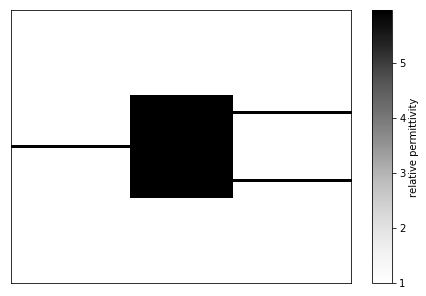

In [22]:
# define permittivity of three port system
eps_r, design_region = three_port(L, H, w, d, l, spc, dl, NPML, eps_m)
(Nx, Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)            # halfway grid points

simulation = Simulation(omega,eps_r,dl,NPML,pol)
# compute the grid size the total grid size
print("Computed a domain with {} grids in x and {} grids in y".format(Nx,Ny))
print("The simulation has {} grids per free space wavelength".format(int(lambda0/dl/simulation.L0)))
simulation.plt_eps(outline=False)
plt.show()

In [23]:
# set the modal source and probes
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(H/2/dl), scale=source_amp)
simulation.setup_modes()

# top modal profile
top = Simulation(omega, eps_r, dl, NPML, 'Ez')
top.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny+int(d/2/dl)], int(H/2/dl))
top.setup_modes()
J_top = np.abs(top.src)

# bottom modal profile
bot = Simulation(omega, eps_r, dl, NPML, 'Ez')
bot.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], int(H/2/dl))
bot.setup_modes()
J_bot = np.abs(bot.src)

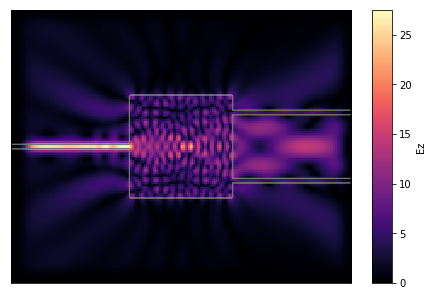

In [24]:
# set source and solve for electromagnetic fields
(_, _, Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);

In [25]:
# compute straight line simulation
eps_r_wg, _ = two_port(L, H, w, l, spc, dl, NPML, eps_start=eps_m)
(Nx_wg, Ny_wg) = eps_r_wg.shape
nx_wg, ny_wg = int(Nx_wg/2), int(Ny_wg/2)            # halfway grid points     
simulation_wg = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
simulation_wg.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny_wg], int(Ny/3), scale=source_amp)
simulation_wg.setup_modes()

# compute normalization
sim_out = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
sim_out.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny], int(Ny/3))
sim_out.setup_modes()
J_out = np.abs(sim_out.src)
(_, _, Ez_wg) = simulation_wg.solve_fields()
SCALE = np.sum(np.square(np.abs(Ez_wg))*J_out)
J_out = J_out
print('computed a scale of {} in units of E^2 J_out'.format(SCALE))

J_top = J_top / SCALE
J_bot = J_bot / SCALE

computed a scale of 953.5595637542929 in units of E^2 J_out


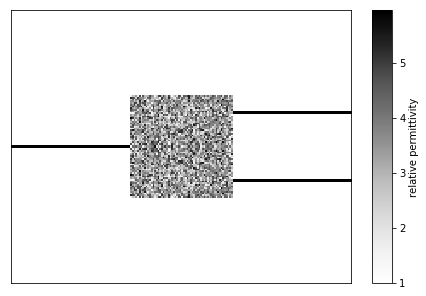

In [26]:
# changes design region. 'style' can be in {'full', 'empty', 'halfway', 'random'}
simulation.init_design_region(design_region, eps_m, style='random_sym')
simulation.plt_eps(outline=False)
plt.show()

In [27]:
# add nonlinearity
nl_region = copy.deepcopy(design_region)

simulation.nonlinearity = []  # This is needed in case you re-run this cell, for example (or you can re-initialize simulation every time)
simulation.add_nl(chi3, nl_region, eps_scale=True, eps_max=eps_m)

In [28]:
# define objective function
import autograd.numpy as npa
def J(e, e_nl):
    linear_top =     1*npa.sum(npa.square(npa.abs(e))*J_top)
    linear_bot =     1*npa.sum(npa.square(npa.abs(e))*J_bot)
    nonlinear_top =  1*npa.sum(npa.square(npa.abs(e_nl))*J_top)
    nonlinear_bot =  1*npa.sum(npa.square(npa.abs(e_nl))*J_bot)
    objfn = ( (linear_top - nonlinear_top) + (nonlinear_bot - linear_bot) ) / 2
    return objfn

In [30]:
# make optimization object and check derivatives
R = 4     # filter radius of curvature (pixels)  (takes a while to set up as R > 5-10)
beta = 300
eta= 0.50
simulation.init_design_region(design_region, eps_m, style='random_sym')
optimization = Optimization(J=J, simulation=simulation, design_region=design_region, eps_m=eps_m, R=R, beta=beta, eta=eta)

 98% (148 of 151) |##################### | Elapsed Time: 0:00:11 ETA:   0:00:00

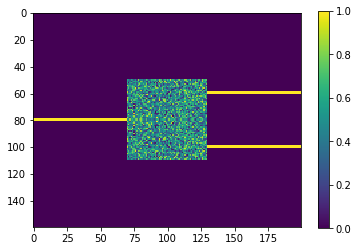

In [31]:
plt.imshow(simulation.rho.T)
plt.colorbar()
plt.show()

In [32]:
# check the derivatives (note, full derivatives are checked, linear and nonlinear no longer separate)
(grad_avm, grad_num) = optimization.check_deriv(Npts=5, d_rho=5e-4)
print('adjoint gradient   = {}\nnumerical gradient = {}'.format(grad_avm, grad_num))

adjoint gradient   = [-2.106171430740639e-07, -1.6522241506549773e-06, -6.254255076445695e-06, 1.873143662906203e-05, -9.727342129803068e-07]
numerical gradient = [-2.1007409700679602e-07, -1.6569634969654246e-06, -6.234569777108234e-06, 1.8812887858654648e-05, -9.749316354223936e-07]


In [44]:
# optimization.beta = 200
# optimization.eta = 0.5
new_eps = optimization.run(method='lbfgs', Nsteps=1000, step_size=1e-2)

 ObjectiveFn:  0.604 Iteration:  131/1000 ETA:   1:46:51                       

KeyboardInterrupt: 

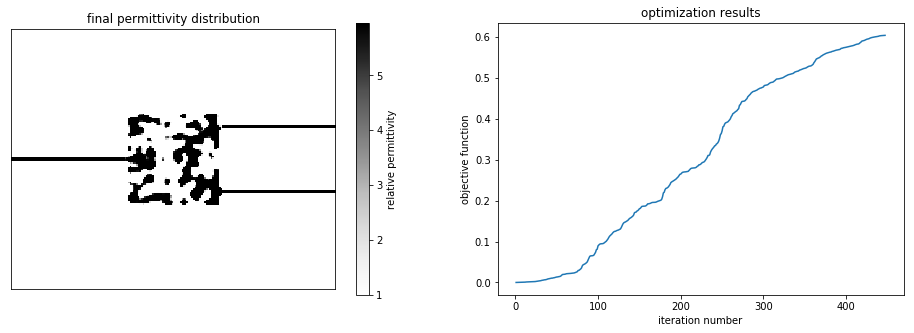

In [45]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
simulation.plt_eps(ax=ax1, outline=False)
ax1.set_title('final permittivity distribution')
optimization.plt_objs(ax=ax2)
ax2.set_yscale('linear')
plt.show()

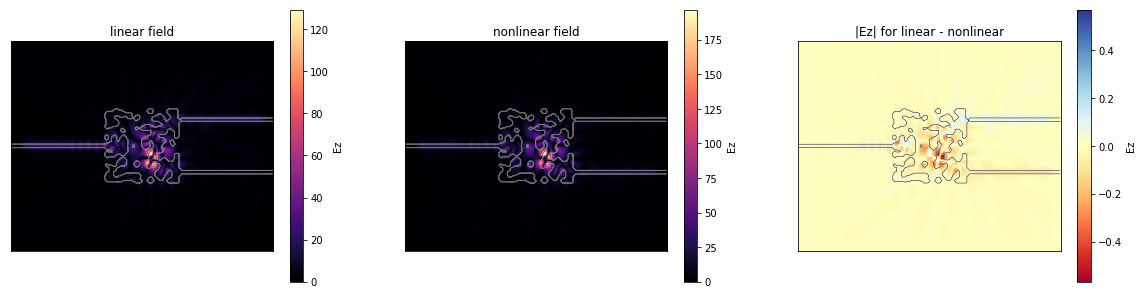

In [46]:
# compare the linear and nonlinear fields

# setup subplots
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

# linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(ax=ax1, vmax=None)
ax1.set_title('linear field')

# nonlinear fields
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
simulation.plt_abs(ax=ax2, vmax=None, nl=True)
ax2.set_title('nonlinear field')

# difference
simulation.plt_diff(ax=ax3)
ax3.set_title('|Ez| for linear - nonlinear')

plt.show()

maximum refractive index shift of 0.009701751910792478


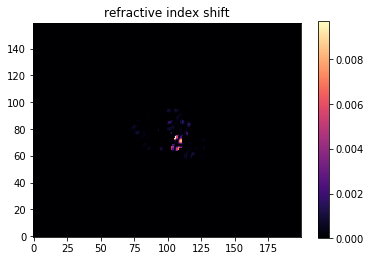

In [47]:
# compute the refractive index shift
index_shift = simulation.compute_index_shift()
print('maximum refractive index shift of {}'.format(np.max(index_shift)))
plt.imshow(index_shift.T, cmap='magma', origin='lower')
plt.colorbar()
plt.title('refractive index shift')
plt.show()

        -> W_in = 0.4182101149877193
        -> linear transmission (top)        = 0.7250
        -> linear transmission (bottom)     = 0.0714
        -> nonlinear transmission (top)     = 0.0634
        -> nonlinear transmission (bottom)  = 0.6459


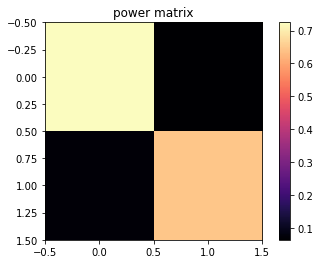

In [48]:
W_in = simulation.W_in
print("        -> W_in = {}".format(W_in))

# linear powers
W_top_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny+int(d/2/dl)], int(H/2/dl))
W_bot_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], int(H/2/dl))

# nonlinear powers
W_top_nl = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny+int(d/2/dl)], int(H/2/dl), nl=True)
W_bot_nl = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], int(H/2/dl), nl=True)


print('        -> linear transmission (top)        = {:.4f}'.format(W_top_lin / W_in))
print('        -> linear transmission (bottom)     = {:.4f}'.format(W_bot_lin / W_in))
print('        -> nonlinear transmission (top)     = {:.4f}'.format(W_top_nl / W_in))
print('        -> nonlinear transmission (bottom)  = {:.4f}'.format(W_bot_nl / W_in))

S = [[W_top_lin / W_in, W_top_nl / W_in],
          [W_bot_lin / W_in, W_bot_nl / W_in]]

plt.imshow(S, cmap='magma')
plt.colorbar()
plt.title('power matrix')
plt.show()

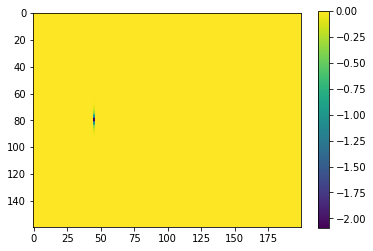

In [54]:
plt.imshow(simulation.src.T)

In [95]:
probe_top = lambda simulation: simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny+int(d/2/dl)], int(H/2/dl), nl=True)
probe_bot = lambda simulation: simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], int(H/2/dl), nl=True)
probes = [probe_top, probe_bot]
powers, transmissions = optimization.scan_power(probes=probes, Ns=50, s_min=0.8, s_max=4e0, solver='newton')
powers_born, transmissions_born = optimization.scan_power(probes=probes, Ns=50, s_min=0.8, s_max=4e0, solver='born')

[autoreload of fdfdpy.simulation failed: Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 369, in superreload
    module = reload(module)
  File "/anaconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/anaconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/twh/Documents/Fan/Code/fdfdpy/fdfdpy/simulation.py", line 8, in <module>
    from fdfdpy.nonlinear_solvers import born_solve, newton_solve, newton_krylov_solve
ImportError: cannot import name 'newton_krylov

trying born


  4% (2 of 50) |#                        | Elapsed Time: 0:00:01 ETA:   0:00:30

woiked
trying born


  6% (3 of 50) |#                        | Elapsed Time: 0:00:02 ETA:   0:00:40

woiked
trying born


  8% (4 of 50) |##                       | Elapsed Time: 0:00:03 ETA:   0:00:59

woiked
trying born


 10% (5 of 50) |##                       | Elapsed Time: 0:00:05 ETA:   0:01:01

woiked
trying born


 12% (6 of 50) |###                      | Elapsed Time: 0:00:06 ETA:   0:01:01

woiked
trying born


 14% (7 of 50) |###                      | Elapsed Time: 0:00:08 ETA:   0:00:59

woiked
trying born


 16% (8 of 50) |####                     | Elapsed Time: 0:00:09 ETA:   0:00:58

woiked
trying born


 18% (9 of 50) |####                     | Elapsed Time: 0:00:10 ETA:   0:00:57

woiked
trying born


 20% (10 of 50) |####                    | Elapsed Time: 0:00:12 ETA:   0:00:56

woiked
trying born


 22% (11 of 50) |#####                   | Elapsed Time: 0:00:13 ETA:   0:00:55

woiked
trying born


 24% (12 of 50) |#####                   | Elapsed Time: 0:00:15 ETA:   0:00:57

woiked
trying born


 26% (13 of 50) |######                  | Elapsed Time: 0:00:16 ETA:   0:00:55

woiked
trying born


 28% (14 of 50) |######                  | Elapsed Time: 0:00:18 ETA:   0:00:54

woiked
trying born


 30% (15 of 50) |#######                 | Elapsed Time: 0:00:20 ETA:   0:00:59

woiked
trying born


 32% (16 of 50) |#######                 | Elapsed Time: 0:00:21 ETA:   0:00:59

woiked
trying born


 34% (17 of 50) |########                | Elapsed Time: 0:00:23 ETA:   0:00:56

woiked
trying born


 36% (18 of 50) |########                | Elapsed Time: 0:00:25 ETA:   0:00:56

woiked
trying born


 38% (19 of 50) |#########               | Elapsed Time: 0:00:27 ETA:   0:00:55

woiked
trying born


 40% (20 of 50) |#########               | Elapsed Time: 0:00:29 ETA:   0:00:55

woiked
trying born


 42% (21 of 50) |##########              | Elapsed Time: 0:00:31 ETA:   0:01:09

woiked
trying born


 44% (22 of 50) |##########              | Elapsed Time: 0:00:33 ETA:   0:01:03

woiked
trying born


 46% (23 of 50) |###########             | Elapsed Time: 0:00:35 ETA:   0:00:57

woiked
trying born


 48% (24 of 50) |###########             | Elapsed Time: 0:00:38 ETA:   0:00:56

woiked
trying born


 50% (25 of 50) |############            | Elapsed Time: 0:00:40 ETA:   0:00:57

woiked
trying born


 52% (26 of 50) |############            | Elapsed Time: 0:00:42 ETA:   0:01:01

woiked
trying born


 54% (27 of 50) |############            | Elapsed Time: 0:00:45 ETA:   0:01:10

woiked
trying born


 56% (28 of 50) |#############           | Elapsed Time: 0:00:49 ETA:   0:01:13

woiked
trying born


 57% (29 of 50) |#############           | Elapsed Time: 0:00:52 ETA:   0:01:06

woiked
trying born


 60% (30 of 50) |##############          | Elapsed Time: 0:00:56 ETA:   0:01:11

woiked
trying born


 62% (31 of 50) |##############          | Elapsed Time: 0:01:00 ETA:   0:01:16

woiked
trying born


 64% (32 of 50) |###############         | Elapsed Time: 0:01:03 ETA:   0:01:10

woiked
trying born


 66% (33 of 50) |###############         | Elapsed Time: 0:01:07 ETA:   0:01:03

woiked
trying born


 68% (34 of 50) |################        | Elapsed Time: 0:01:11 ETA:   0:01:06

woiked
trying born


 70% (35 of 50) |################        | Elapsed Time: 0:01:16 ETA:   0:01:06

woiked
trying born


 72% (36 of 50) |#################       | Elapsed Time: 0:01:21 ETA:   0:01:08

woiked
trying born


 74% (37 of 50) |#################       | Elapsed Time: 0:01:27 ETA:   0:01:15

woiked
trying born


 76% (38 of 50) |##################      | Elapsed Time: 0:01:33 ETA:   0:01:21

woiked
trying born


 78% (39 of 50) |##################      | Elapsed Time: 0:01:40 ETA:   0:01:18

woiked
trying born


 80% (40 of 50) |###################     | Elapsed Time: 0:01:46 ETA:   0:00:52

woiked
trying born


 82% (41 of 50) |###################     | Elapsed Time: 0:01:49 ETA:   0:00:29

woiked
trying born


 84% (42 of 50) |####################    | Elapsed Time: 0:01:51 ETA:   0:00:17

woiked
trying born


 86% (43 of 50) |####################    | Elapsed Time: 0:01:54 ETA:   0:00:18

woiked
trying born


 88% (44 of 50) |#####################   | Elapsed Time: 0:01:58 ETA:   0:00:22

woiked
trying born


 90% (45 of 50) |#####################   | Elapsed Time: 0:02:05 ETA:   0:00:35

woiked
trying born
the simulation did not converge, reached 3.116838443836608e-08
didnt converge, trying newton


 92% (46 of 50) |######################  | Elapsed Time: 0:02:22 ETA:   0:01:09

didnt woik
trying born
the simulation did not converge, reached 0.19286673521896894
didnt converge, trying newton


 94% (47 of 50) |######################  | Elapsed Time: 0:02:40 ETA:   0:00:53

didnt woik
trying born
the simulation did not converge, reached 0.4873897876467067
didnt converge, trying newton


 96% (48 of 50) |####################### | Elapsed Time: 0:02:58 ETA:   0:00:35

didnt woik
trying born
the simulation did not converge, reached 0.6353741566372273
didnt converge, trying newton


 98% (49 of 50) |####################### | Elapsed Time: 0:03:13 ETA:   0:00:15

didnt woik
trying born
the simulation did not converge, reached 0.7381462129814734
didnt converge, trying newton


100% (50 of 50) |########################| Elapsed Time: 0:03:30 ETA:  00:00:00

didnt woik
trying born
the simulation did not converge, reached 1.076453555439801
didnt converge, trying newton


N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

didnt woik
trying born


  4% (2 of 50) |#                        | Elapsed Time: 0:00:01 ETA:   0:00:31

woiked
trying born


KeyboardInterrupt: 

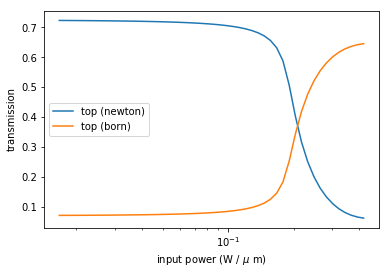

In [97]:
for probe_index, _ in enumerate(probes):
    plt.plot(powers, transmissions[probe_index])
#     plt.plot(powers_born, transmissions_born[probe_index])
    
plt.xscale('log')
plt.xlabel('input power (W / $\mu$ m)')
plt.legend(('top (newton)', 'top (born)', 'bottom (newton)', 'bottom (born)'))
plt.ylabel('transmission')
plt.show()

In [ ]:
freqs, objs, FWHM = optimization.scan_frequency(Nf=200, df=1/400)
optimization.simulation.omega = omega
plt.plot([(f-150e12)/1e9 for f in freqs], objs)
plt.xlabel('frequency difference (GHz)')
plt.ylabel('objective function')
plt.show()
print('computed FWHM of {} (GHz):'.format(FWHM/1e9))
print('Q factor of {0:.2E}'.format(omega/2/np.pi/FWHM))

In [99]:
from data.device_saver import Device
D = Device(simulation, optimization)
D.set_parameters(lambda0, dl, NPML, chi3, eps_m, source_amp)
D.set_geometry('three_port', L, H, w, d, l, spc, dl, NPML, eps_m)
# D.generate_data(Nf=200)
with open('~/Desktop/test.p', "wb") as f:
    pickle.dump(D, f)

loading in simulation and optimization...
    solving fields
setting parameters...
setting geometry parameters...


FileNotFoundError: [Errno 2] No such file or directory: '~/Desktop/test.p'

In [101]:
import dill as pickle
with open('../test.p', "wb") as f:
    pickle.dump(D, f)

PicklingError: Can't pickle <class 'fdfdpy.simulation.Simulation'>: it's not the same object as fdfdpy.simulation.Simulation